# Analyze poly(A) tail length differences between PABPN1 mutants

In [1]:
###Load Packages

#Functions for polyA specific analysis (must be in same path)
from polyA_utils import *

#Packages for general column manipulation and statistics
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from scipy import stats
import scipy.stats as sci
import pysam

#Packages for plotting
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#Color palette for plots
four_palette = ["darkgreen", "tomato", "steelblue", "orange"]
two_palette = ["steelblue", "orange"]

In [3]:
figpath = "./"

### Global analysis of poly(A) tail lengths

Question: Do PABPN1 mutants display differences in poly(A) tail lengths? 

First define a function to import poly(A) tail lengths dataframes (each read has one tail length) produced in the Snakemake pipeline

In [4]:
#Function to read polyA tab del files
def read_polyA_reads(file, min_read_count, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df = df.loc[df['tail_len'] >= min_read_count]
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

Set master path that points to the experiment directory

In [5]:
#path to the data
path = "/path/to/data/"

In [6]:
#Read in dfs, assign to variables
min_A_count = 10

h112_1 = read_polyA_reads(path + 'results/polyA_len/h112.R1_polyA.txt', min_A_count, "EV", "1")
h112_2 = read_polyA_reads(path + 'results/polyA_len/h112.R2_polyA.txt', min_A_count, "EV", "2")

h113_1 = read_polyA_reads(path + 'results/polyA_len/h113.R1_polyA.txt', min_A_count, "WT", "1")
h113_2 = read_polyA_reads(path + 'results/polyA_len/h113.R2_polyA.txt', min_A_count, "WT", "2")

h115_1 = read_polyA_reads(path + 'results/polyA_len/h115.R1_polyA.txt', min_A_count, "4SA", "1")
h115_2 = read_polyA_reads(path + 'results/polyA_len/h115.R2_polyA.txt', min_A_count, "4SA", "2")

h117_1 = read_polyA_reads(path + 'results/polyA_len/h117.R1_polyA.txt', min_A_count, "4SD", "1")
h117_2 = read_polyA_reads(path + 'results/polyA_len/h117.R2_polyA.txt', min_A_count, "4SD", "2")

#Path to gene types df (from gtf)
gene_types = pd.read_csv(path + "config/gene_types_df.tsv", sep = "\t")

#Combine replicates and intersect with gene names
all_reads = pd.concat([h112_1, h112_2, h113_1, h113_2, h115_1, h115_2, h117_1, h117_2], ignore_index = True)
all_reads["gene_id"] = all_reads["gene_id"].str.split(".").str[0]
all_reads = all_reads.merge(gene_types, on = 'gene_id')

Percentage of reads that are polyadenylated:

In [7]:
#Caclulate the total number of reads (from wc -l on mapped bed files)
tot_reads = 3540316 #from (wc -l)/4 of all_reads.fastq
print("number of genome mapped reads with poly(A) tails: " + str(len(all_reads)))
print("percentage of mapped reads with poly(A) tails: " + str(len(all_reads)/tot_reads * 100))

number of genome mapped reads with poly(A) tails: 2091774
percentage of mapped reads with poly(A) tails: 59.08438681744793


#### Compare polyA tail lengths for all reads between conditions

/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_58369/4246620036.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=all_reads, x = 'Sample', y = 'tail_len', dodge=True, join=False, ci='sd', hue = "Replicate", errorbar=('ci', 95), palette = four_palette, capsize=0.1)


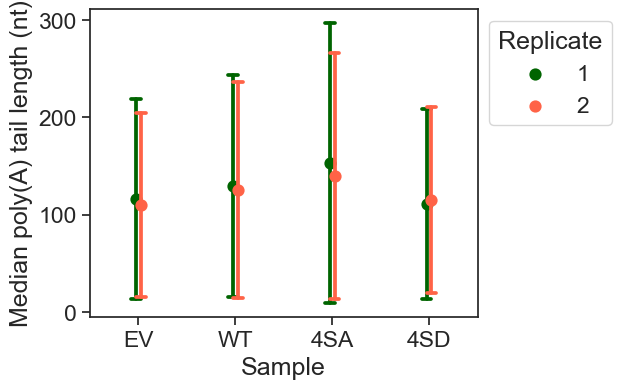

In [8]:
sns.set_style("ticks")
f, ax = plt.subplots(1,1, figsize=(5,4))

sns.pointplot(data=all_reads, x = 'Sample', y = 'tail_len', dodge=True, join=False, ci='sd', hue = "Replicate", errorbar=('ci', 95), palette = four_palette, capsize=0.1)
ax.set_ylabel("Median poly(A) tail length (nt)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Look at the distribution of tail lengths per replicate - is it normally distributed?

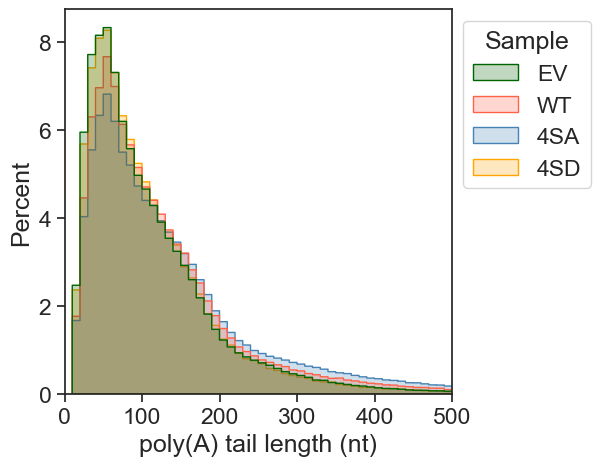

In [9]:
f, ax = plt.subplots(1,1, figsize = (5,5))
sns.histplot(data = all_reads, stat = "percent", hue = "Sample", common_norm = False, x = "tail_len", palette = four_palette, binwidth = 10, element = "step")

ax.set_xlim(0,500)
ax.set_xlabel("poly(A) tail length (nt)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Distributions are not normal but do have roughly the same shape. Can use mannwhitneyu between samples to determine statistical significance

In [10]:
stats.mannwhitneyu(list(all_reads.loc[all_reads["Sample"] == "EV"].tail_len), 
                    list(all_reads.loc[all_reads["Sample"] == "4SD"].tail_len), 
                    axis=0)

MannwhitneyuResult(statistic=77886021708.5, pvalue=0.00134864655311878)

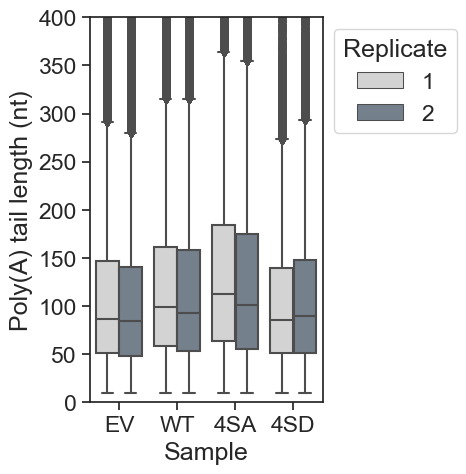

In [11]:
f, ax = plt.subplots(1,1, figsize = (3,5))
sns.boxplot(data = all_reads, x = "Sample", y = "tail_len", palette = ["lightgrey", "slategrey"], hue = "Replicate")

ax.set_ylim(0,400)
ax.set_ylabel("Poly(A) tail length (nt)")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(figpath + 'polA_per_read_replicates.png', dpi=300, bbox_inches="tight")

Make a boxplot of the distribtion of poly(A) tail lengths per read in each condtion


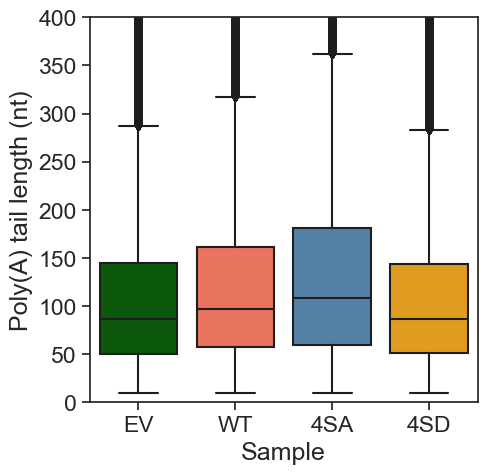

In [12]:
f, ax = plt.subplots(1,1, figsize = (5,5))
sns.boxplot(data = all_reads, x = "Sample", y = "tail_len", palette = four_palette)

ax.set_ylim(0,400)
ax.set_ylabel("Poly(A) tail length (nt)")

plt.savefig(figpath + 'polA_tails_all_reads.png', dpi=300, bbox_inches="tight")

In [13]:
all_reads.groupby("Sample").median()

/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_58369/639043444.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_reads.groupby("Sample").median()


,tail_len
Sample,
4SA,108.0
4SD,87.0
EV,86.0
WT,97.0
